<h2> Figure with results from residence time experiments</h2>

In [3]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils
import process_cl2_logfile as process_cl2#This underline is unavoidable

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

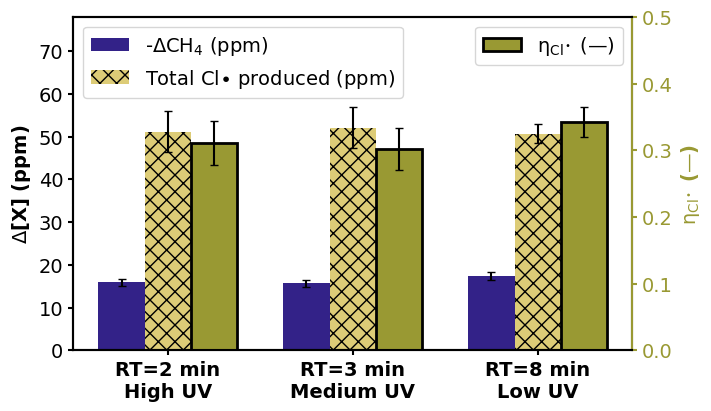

In [4]:
import types
current_data = types.SimpleNamespace()

# Whittle it down to the experiments we want
exps=['12-2 Light Distance Log '+str(i) for i in [1,2,3,4]]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]

# Extract tags
pd.options.mode.chained_assignment = None  # default='warn'
def translate_tags(string):
    str_rep = ("dict("+string.replace(";",",")+")")
    return eval(str_rep)
def get_rt(t):
    if t=='11':
        return '3'
    if t=='25':
        return '8'
    if t=='HP':
        return '2'
conversion_data['Light Pos'] = [translate_tags(t)['light_pos'] for t in conversion_data['tags']]
conversion_data['Exp Type'] = [translate_tags(t)['type'] for t in conversion_data['tags']]
conversion_data = conversion_data[conversion_data['Light Pos']!='18']
conversion_data['Res Time'] = [get_rt(t) for t in conversion_data['Light Pos']]
conversion_data = conversion_data.sort_values(by=['Exp Type','Res Time'])

# We need CH4 conversions and Cl* usage from the CH4 trials, and radical budgets from the radical count trials.
rad_count_conv_data = conversion_data[conversion_data['Exp Type']=='rad_count']
ch4_trial_conv_data = conversion_data[conversion_data['Exp Type']=='ch4_conv']


# Extract the values and 95% CI from the CH4 conversion data
current_data.ch4_baselines = ch4_trial_conv_data["Selected: CH4 (ppm) baseline"]
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(ch4_trial_conv_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = [1000,1000,100]
(current_data.rad_count_baseline, current_data.rad_count_conversions, current_data.rad_count_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(rad_count_conv_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_percent_accuracy_95,override_cl2_baseline=[30,30,30])
current_data.cl_budget = np.array(current_data.rad_count_conversions)*2 #Cl2 --> 2Cl*
current_data.cl_budget_95_ci = current_data.rad_count_conversion_95_ci*2 #Cl2 -->2Cl*

current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl2_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)
current_data.ch4_per_cl = current_data.ch4_conversions/current_data.cl_budget
current_data.ch4_per_cl_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.ch4_conversions,current_data.ch4_95_ci,current_data.cl_budget,current_data.cl_budget_95_ci)

# Compute the Cl2 feed per CH4 converted
current_data.cl2_fed_per_ch4_converted = current_data.rad_count_baseline/current_data.ch4_conversions

# Save residence times
current_data.residence_times = ch4_trial_conv_data['Res Time']

# Setup and global settings
use_error_bars = True
(fig,ax)=plt.subplots(figsize=(7,4))

ax_right = ax.twinx()

#cl2_utils.do_error_bar(ax,line_default_properties,'CH4',current_data.residence_times,current_data.ch4_conversions,(current_data.cl2_per_ch4_95_ci if use_error_bars else None))
#cl2_utils.do_error_bar(ax,line_default_properties,'Cl2',current_data.residence_times,current_data.cl_budget,(current_data.cl2_per_ch4_95_ci if use_error_bars else None))
#cl2_utils.do_error_bar(ax_right,line_default_properties,'Cl* Efficiency',current_data.residence_times,current_data.cl_per_ch4,(current_data.cl2_per_ch4_95_ci if use_error_bars else None))
x = np.arange(3)
width = 0.25

bar_names = ['RT=2 min\nHigh UV','RT=3 min\nMedium UV','RT=8 min\nLow UV']
ax.bar(x+0*width,current_data.ch4_conversions,width,color=line_default_properties['CH4']['color'],hatch='',label='-$\Delta$CH$_4$ (ppm)')
ax.errorbar(x+0*width,current_data.ch4_conversions,current_data.ch4_95_ci,linestyle='None',color='k',capsize=3)
ax.bar(x+1*width,current_data.cl_budget,width,color=line_default_properties['Cl2']['color'],hatch='xx',label='Total Cl$\\bullet$ produced (ppm)')
ax.errorbar(x+1*width,current_data.cl_budget,current_data.cl_budget_95_ci,linestyle='None',color='k',capsize=3)
ax_right.bar(x+2*width,current_data.ch4_per_cl,width,color=line_default_properties['Cl* Efficiency']['color'],edgecolor='k',linewidth=2,label=line_default_properties['Cl* Efficiency']['text']+" (—)")
ax_right.errorbar(x+2*width,current_data.ch4_per_cl,current_data.ch4_per_cl_95_ci,linestyle='None',color='k',capsize=3)

ax.set_ylabel("$\Delta$[X] (ppm)",fontweight=plot_default_properties['font_weight'])
ax.xaxis.set_tick_params(labelbottom=True)
ax_right.set_ylabel(line_default_properties['Cl* Efficiency']['text']+" (—)",fontweight=plot_default_properties['font_weight'])
ax_right.xaxis.set_tick_params(labelbottom=True)
right_ax_color = line_default_properties['Cl* Efficiency']['color']
ax_right.tick_params(axis='y', colors=right_ax_color)
ax_right.yaxis.label.set_color(right_ax_color)
ax_right.spines['right'].set_color(right_ax_color)
ax.set_ylim(0,78)
ax_right.set_ylim(0,0.5)

ax.legend(loc='upper left')
ax_right.legend(loc='upper right')

ax.set_xticks(x + width, bar_names,fontweight=plot_default_properties['font_weight'])

for ax in [ax, ax_right]:
    ax.tick_params(width=plot_default_properties['box_linewidth'])
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth'])

for d in [current_data.ch4_conversions, current_data.cl_budget, current_data.cl_per_ch4]:
    vars = np.abs(d-d[1])/d[1]

plt.savefig('exported_images/vary_residence_time_results.png', bbox_inches='tight',dpi=300)
plt.show()
pass
